## Load modules

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

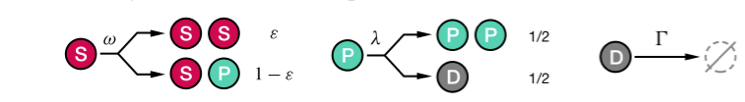

In [2]:
from IPython.display import Image
Image("cell_division.png")

## Stem cell hierarchy

As Lan et al. proposed, a stem cell hierachy in Glioblastoma development consists of three different cell types: stem cell, progenitor cell and differentiated cell. As shown in Figure, a stem cell could divide into either two stem cells (symmetrical cell division) or one stem cell and one progenitor cell (asymmetrical cell division); a progenitor cell could either divide into two progenitor cells (cell division) or differentiate into one differentiated cell (cell division); and a differentiated cell will eventually undergo cell apoptosis.

In the following clonalSizeSimulation/clonalGrowthSimulation, stochastic simulation is applied to five reactions:

    Reaction 1: S > S + S,    rate of reaction k1 = omega * epsilon
    Reaction 2: S > S + P,    rate of reaction k2 = omega * (1 - epsilon)
    Reaction 3: P > P + P,    rate of reaction k3 = lambda * 0.5
    Reaction 4: P > D,        rate of reaction k4 = lambda * 0.5
    Reaction 5: D > none,     rate of reaction k5 = gamma
    
For each simulation, 
    
    1. the propensity function for each reaction is calculated based of the number reactant cells (S, P, D) in the population and the rate of reaction;
    2. a first random number is generated to decide time for next reaction;
    3. a second random number is generated to decide which reaction occurs next;
    4. as the reaction occurs, the number of cells (reactant and product) in the population is updated.

In [3]:
def clonalSizeSimulation(stemDivRate, epsilon, proDivRate, apoptosisRate,countingTimePoint,seed):
    S = 1
    P = 0
    D = 0
    reactionTime = 0
    random.seed(seed)
#     Reaction 1: S > S + S, rate of reaction (k1) = stemDivRate * epsilon
    k1 = stemDivRate*epsilon
#     Reaction 2: S > S + P, rate of reaction (k2) = stemDivRate * (1 - epsilon)
    k2 = stemDivRate*(1-epsilon)        
#     Reaction 3: P > P + P, rate of reaction (k3) = proDivRate * 0.5
    k3 = proDivRate*0.5    
#     Reaction 4: P > D, rate of reaction (k4) = proDivRate * 0.5
    k4 = proDivRate*0.5    
#     Reaction 5: D > none, rate of reaction (k5) = apoptosisRate
    k5 = apoptosisRate

    cont = True  
    while(cont):
#         Reaction 1: propensity function (A1) = S(t) * k1
        A1 = S*k1
#         Reaction 2: propensity function (A2) = S(t) * k2
        A2 = S*k2    
#         Reaction 3: propensity function (A3) = P(t) * k3
        A3 = P*k3
#         Reaction 4: propensity function (A4) = P(t) * k4
        A4 = P*k4
#         Reaction 5: propensity function (A5) = D(t) * k5
        A5 = D*k5
        A0 = A1 + A2 + A3 + A4 + A5

#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime + t > countingTimePoint:
            N = S + P + D
            cont = False
        else:
            reactionTime += t
#             second random number generator to determine which reaction occurs
#             random.seed(seed+1)
            r2 = random.random()
            if r2 < A1/A0:
                S += 1
            elif r2 < (A1+A2+A3)/A0:
                P += 1
            elif r2 < (A1+A2+A3+A4)/A0:
                P -= 1
                D += 1
            else:
                D -= 1
            N = S + P + D
#             print('reaction time = ' + str(reactionTime))
#             print('clone size = ' + str(N))
    return(N)

%time sizes = clonalSizeSimulation(stemDivRate=0.1, epsilon=0.1, proDivRate=1.5, apoptosisRate=0.74,countingTimePoint=50,seed=5)

CPU times: user 299 µs, sys: 13 µs, total: 312 µs
Wall time: 325 µs


In [4]:
def clonalGrowthSimulation(stemDivRate, epsilon, proDivRate, apoptosisRate,countingTimePoint):
    S = np.array([1])
    P = np.array([0])
    D = np.array([0])
    N = np.array([1])
    reactionTime = np.array([0])
    
#     Reaction 1: S > S + S, rate of reaction (k1) = stemDivRate * epsilon
    k1 = stemDivRate*epsilon
#     Reaction 2: S > S + P, rate of reaction (k2) = stemDivRate * (1 - epsilon)
    k2 = stemDivRate*(1-epsilon)        
#     Reaction 3: P > P + P, rate of reaction (k3) = proDivRate * 0.5
    k3 = proDivRate*0.5    
#     Reaction 4: P > D, rate of reaction (k4) = proDivRate * 0.5
    k4 = proDivRate*0.5    
#     Reaction 5: D > none, rate of reaction (k5) = apoptosisRate
    k5 = apoptosisRate
    
    cont = True  
    while(cont):
#         Reaction 1: propensity function (A1) = S(t) * k1
        A1 = S[-1]*k1
#         Reaction 2: propensity function (A2) = S(t) * k2
        A2 = S[-1]*k2    
#         Reaction 3: propensity function (A3) = P(t) * k3
        A3 = P[-1]*k3
#         Reaction 4: propensity function (A4) = P(t) * k4
        A4 = P[-1]*k4
#         Reaction 5: propensity function (A5) = D(t) * k5
        A5 = D[-1]*k5
        A0 = A1 + A2 + A3 + A4 + A5

#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime[-1] + t > countingTimePoint:
            cont = False
        else:
            reactionTime = np.append(reactionTime,reactionTime[-1] + t)

#             second random number generator to determine which reaction occurs
            r2 = random.random()
            if r2 < A1/A0:
                S = np.append(S, S[-1]+1)
            elif r2 < (A1+A2+A3)/A0:
                P = np.append(P, P[-1]+1)
            elif r2 < (A1+A2+A3+A4)/A0:
                P = np.append(P, P[-1]-1)
                D = np.append(D, D[-1]+1)
            else:
                D = np.append(D, D[-1]-1)
            N = np.append(N, S[-1]+P[-1]+D[-1])
    print('final reaction time = ' + str(reactionTime[-1]))
    print('final clone size = ' + str(N[-1]))
    clonalGrowth = np.concatenate((reactionTime, N), axis=0)
    return{"reaction_time": reactionTime, "clone_size": N}

%time growth = clonalGrowthSimulation(stemDivRate=0.1, epsilon=0.1, proDivRate=1.5, apoptosisRate=0.74,countingTimePoint=50)

final reaction time = 49.95053521222033
final clone size = 16
CPU times: user 11 ms, sys: 2.84 ms, total: 13.8 ms
Wall time: 11.8 ms


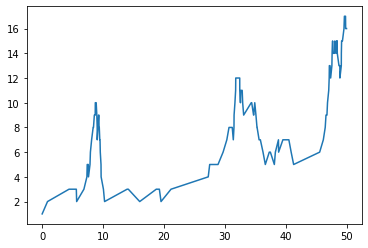

In [5]:
plt.plot(growth["reaction_time"],growth["clone_size"])

CPU times: user 6.15 s, sys: 31.4 ms, total: 6.18 s
Wall time: 6.22 s


(array([793., 114.,  43.,  17.,  11.,  12.,   2.,   4.,   1.,   3.]),
 array([  1. ,  53.1, 105.2, 157.3, 209.4, 261.5, 313.6, 365.7, 417.8,
        469.9, 522. ]),
 <a list of 10 Patch objects>)

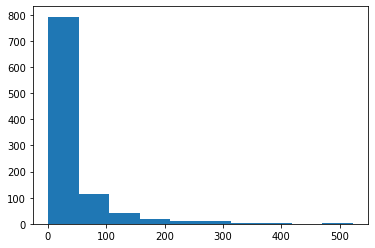

In [6]:
def multiSimulation(n):
    # N: the number of parallele tasks   
    simulation = 1000
    clones = np.zeros(simulation)
    for i in range(simulation):
        clones[i] = clonalSizeSimulation(stemDivRate=0.1, epsilon=0.1, proDivRate=1.5, apoptosisRate=0.74,countingTimePoint=100, seed=n*simulation+i)
    return(clones)

%time testing = multiSimulation(5)
plt.hist(testing)

In [7]:
if __name__ == '__main__':
    with Pool(8) as p:
        %time result = p.map(multiSimulation, range(10))

CPU times: user 26.9 ms, sys: 7.25 ms, total: 34.1 ms
Wall time: 33.5 s


(array([9.064e+03, 6.370e+02, 1.840e+02, 6.900e+01, 2.800e+01, 1.300e+01,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([1.000e+00, 1.067e+02, 2.124e+02, 3.181e+02, 4.238e+02, 5.295e+02,
        6.352e+02, 7.409e+02, 8.466e+02, 9.523e+02, 1.058e+03]),
 <a list of 10 Patch objects>)

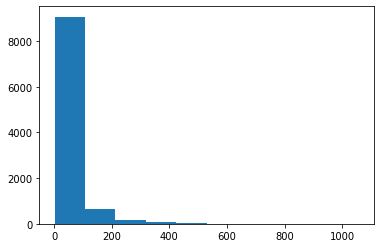

In [8]:
cloneSizes = np.concatenate(result)
plt.hist(cloneSizes)

In [9]:
def negativeBinomialDistribution(divisionRate, countingTimePoint, n):
    n0 = divisionRate * countingTimePoint / 2
    N0 = np.log(n0)
    P = 1 / N0 * np.exp(-n/n0) / n
    return(P)

cloneSizeRange = np.asarray(range(int(max(cloneSizes))))
%time NBD = negativeBinomialDistribution(divisionRate=1.5, countingTimePoint=100, n=cloneSizeRange)

CPU times: user 1.5 ms, sys: 1.52 ms, total: 3.02 ms
Wall time: 3.85 ms


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


minimum clone size = 1
maximum clone size = 1058


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


CPU times: user 3.2 s, sys: 29.2 ms, total: 3.23 s
Wall time: 3.27 s


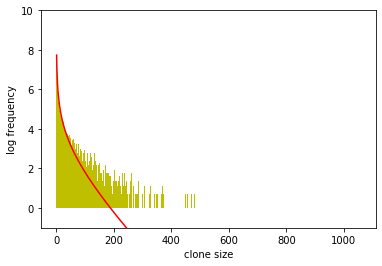

In [13]:
def logSizeDistribution(cloneSizes,NBD):
    minimum = int(min(cloneSizes))
    print('minimum clone size = ' + str(minimum))
    maximum = int(max(cloneSizes))
    print('maximum clone size = ' + str(maximum))
    x = np.asarray(range(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i+1) for i in range(maximum)])
    plt.bar(x,np.log(freq),width=2,color='y') 
    plt.plot(x, np.log(len(cloneSizes)*NBD), 'r')
    plt.ylim((-1, 10))
    plt.xlabel('clone size')
    plt.ylabel('log frequency')
    
%time logSizeDistribution(cloneSizes,NBD)